### Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
%matplotlib inline

pd.set_option('precision', 3)

### Importing the dataset

In [2]:
labels = ('fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides','free_sulfur_dioxide','total_sulfur_dioxide','density','pH','sulphates','alcohol','quality')
df_red = pd.read_csv('Datasets/winequality-red.csv', header = 0, names = labels,sep = ';')

### Display the dataset

In [3]:
df_red.head(2)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.0,1.9,0.076,11.0,34.0,0.998,3.51,0.56,9.4,5
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.997,3.20,0.68,9.8,5


In [4]:
def drop_constant_column(dataframe):
    return dataframe.loc[:, (dataframe != dataframe.iloc[0]).any()]

def cleanDf(df):
    columns_len = len(df.columns)
    # clear empty or "singular" columns
    df = df.dropna(axis='columns', how='all')
    df = drop_constant_column(df)
    len_before_drop = len(df)
    df = df.drop_duplicates()
    print(f"Loaded {len_before_drop} records, removed {len_before_drop - len(df)} duplicates, left {len(df)}, removed {columns_len-len(df.columns)} of {columns_len} columns")

    return df

#### Dropping the Duplicate Values and normalizing data

In [5]:
#loading data into MinMax scaler to change min=0 and max=1 of every column
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
df_red = cleanDf(df_red)
scaler = MinMaxScaler()
scaler.fit(df_red)
d = scaler.transform(df_red)
scaled_df = pd.DataFrame(d, columns=labels)
scaled_df.head()

Loaded 1599 records, removed 240 duplicates, left 1359, removed 0 of 12 columns


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,0.248,0.397,0.00,0.068,0.107,0.141,0.099,0.568,0.606,0.138,0.154,0.4
1,0.283,0.521,0.00,0.116,0.144,0.338,0.216,0.494,0.362,0.210,0.215,0.4
2,0.283,0.438,0.04,0.096,0.134,0.197,0.170,0.509,0.409,0.192,0.215,0.4
3,0.584,0.110,0.56,0.068,0.105,0.225,0.191,0.582,0.331,0.150,0.215,0.6
4,0.248,0.370,0.00,0.062,0.105,0.169,0.120,0.568,0.606,0.138,0.154,0.4


## Exploratory Data Analysis

In [6]:
def get_features(df, label, threshold):
    correlations = df.corr()[label].drop(label)
    features = correlations[correlations.abs() > threshold].index.tolist()
    df_filtered = df[features + [label]]

    return df_filtered, features, correlations

In [7]:
label = 'quality'
scaled_df_features, features, _ = get_features(scaled_df, label, 0.1)

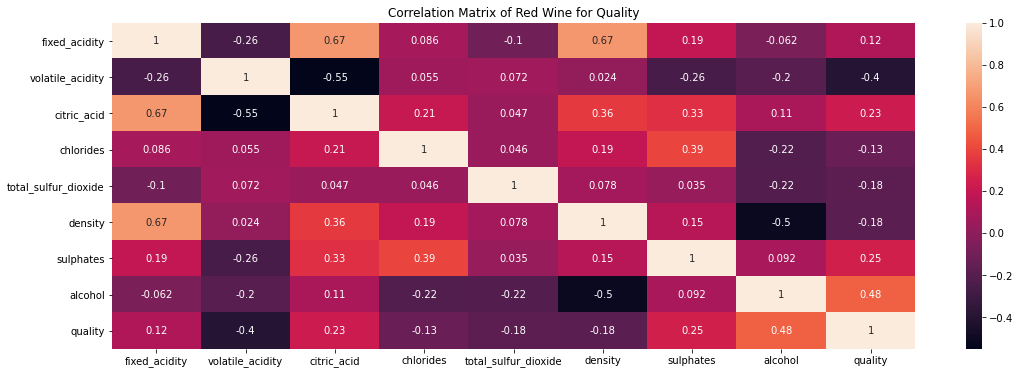

In [8]:
plt.figure(figsize=(18,6))
sns.heatmap(scaled_df_features.corr(),annot=True)
plt.title('Correlation Matrix of Red Wine for Quality');

# Compare Predictions for Red Wine

### Splitting into Train and Test sets

In [9]:
from sklearn.model_selection import train_test_split

X = scaled_df[features]
y = scaled_df[label]
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [10]:
X.head(2)

,fixed_acidity,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,density,sulphates,alcohol
0,0.248,0.397,0.0,0.107,0.099,0.568,0.138,0.154
1,0.283,0.521,0.0,0.144,0.216,0.494,0.210,0.215


In [11]:
y.head(2)

0    0.4
1    0.4
Name: quality, dtype: float64

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [13]:
lr_train_pred = lr.predict(X_train)
print(f'Train Prediction: {lr_train_pred[:15].astype(float)}\n   Actual values: {y_train[:15].values}')
lr_test_pred = lr.predict(X_test)
print(f'Test  Prediction: {lr_test_pred[:15].astype(float)}\n   Actual values: {y_test[:15].values}')

Train Prediction: [0.41696654 0.4998864  0.57116935 0.46426535 0.50989195 0.61574657
 0.36791434 0.56189885 0.39694115 0.57595776 0.63096213 0.62001388
 0.40504745 0.61476186 0.43682876]
   Actual values: [0.4 0.8 0.6 0.4 0.4 0.6 0.4 0.8 0.4 0.6 0.6 0.8 0.4 0.8 0.4]
Test  Prediction: [0.63094384 0.39226947 0.75965946 0.628169   0.51551542 0.71743784
 0.5491511  0.73057096 0.69972363 0.62897545 0.46213126 0.52835869
 0.42948811 0.46504947 0.37631617]
   Actual values: [0.4 0.4 0.6 0.8 0.6 0.6 0.4 0.8 0.8 0.6 0.6 0.6 0.6 0.4 0.2]


In [14]:
lr_rmse_train = metrics.mean_squared_error(lr_train_pred, y_train) ** 0.5
print(f'LinearRegression train RMSE {lr_rmse_train:.2f}')

lr_rmse_test = metrics.mean_squared_error(lr_test_pred, y_test) ** 0.5
print(f'LinearRegression test  RMSE {lr_rmse_test:.2f}')

LinearRegression train RMSE 0.13
LinearRegression test  RMSE 0.14


#### Using AUTO ML

In [15]:
import autosklearn
from sklearn.metrics import mean_absolute_error
from autosklearn.regression import AutoSklearnRegressor
from autosklearn.metrics import mean_absolute_error as auto_mean_absolute_error
print(f'autosklearn: {autosklearn.__version__}')

autosklearn: 0.12.6


In [16]:
def prediction_out(name, estimator):
    train_pred = estimator.predict(X_train)
    test_pred = estimator.predict(X_test)
    rmse_train = metrics.mean_squared_error(train_pred, y_train) ** 0.5
    rmse_test = metrics.mean_squared_error(test_pred, y_test) ** 0.5
    print(f'{name} train RMSE {rmse_train:.3f}')
    print(f'{name} test  RMSE {rmse_test:.3f}')
    return rmse_train, rmse_test, train_pred, test_pred

In [17]:
# define search
model_mae = AutoSklearnRegressor(time_left_for_this_task=2*60, metric=auto_mean_absolute_error, per_run_time_limit=30, n_jobs=-1)

In [18]:
# perform the search
%time model_mae.fit(X_train, y_train)

CPU times: user 1min 19s, sys: 3.41 s, total: 1min 23s
Wall time: 2min 6s


AutoSklearnRegressor(metric=mean_absolute_error, n_jobs=-1,
                     per_run_time_limit=30, time_left_for_this_task=120)

In [19]:
# summarize
print(model_mae.sprint_statistics())
# evaluate best model_mae
ar_train_pred = model_mae.predict(X_train)
ar_test_pred = model_mae.predict(X_test)
mae = mean_absolute_error(y_test, ar_test_pred)
print(f"MAE: {mae:.2f}")

auto-sklearn results:
  Dataset name: b48a4b69-e1a9-11eb-905b-b5d5efc8800d
  Metric: mean_absolute_error
  Best validation score: 0.095150
  Number of target algorithm runs: 33
  Number of successful target algorithm runs: 21
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 12
  Number of target algorithms that exceeded the memory limit: 0

MAE: 0.10


In [20]:
prediction_out('AutoSklearn', model_mae);

AutoSklearn train RMSE 0.120
AutoSklearn test  RMSE 0.135


**KERAS**

In [21]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import logging
tf.get_logger().setLevel(logging.ERROR)

In [22]:
# define base model wraper
def baseline_model_arg(activation_type):
    # create model
    def baseline_model():
        model = Sequential()
        model.add(Dense(12, input_dim=8, kernel_initializer='normal', activation=activation_type))
        model.add(Dense(8, activation=activation_type))
        model.add(Dense(1, kernel_initializer='normal'))
        # Compile model
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model
    return baseline_model

In [23]:
#define keras model function serealization
def KerasRMSE(epoch, batches, activator, verbosity=0):
    kfold_s = KFold(n_splits=10)
    estimator_ks = KerasRegressor(build_fn=baseline_model_arg(activator), epochs=epoch, batch_size=batches, verbose=verbosity)
    %time results_s = cross_val_score(estimator_ks, X, y, cv=kfold_s)
    callbacks_list = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='./models/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir=f'./logs/{date.today().strftime("%b-%d-%Y")}'),]
    estimator_ks.fit(X_train, y_train, validation_split=0.33, callbacks=callbacks_list)
                    
    return estimator_ks

In [24]:
activations_full = ['relu', 'sigmoid', 'softmax', 'softplus']
def KerasAuto(activators, epochs, verbosity=0):
    batches = 5
    estimator_ks_1 = KerasRMSE(epochs[0], batches, activators[0], verbosity)
    o1, o2, _, _ = prediction_out(f'keras {epochs[0]} {batches}', estimator_ks_1)
    for i, activator in enumerate(activators):
        for j, epoch in enumerate(epochs):
            if i == 0 and j == 0:
                continue
            estimator_ks_2 = KerasRMSE(epoch, batches, activator, verbosity)
            l1, l2, _, _ = prediction_out(f'keras {epoch} {batches}', estimator_ks_2)
            if l2 > o2 and abs(o2 - o1) < abs(l2 - l1):
                break
            if l2 < o2:
                o1 = l1
                o2 = l2
                estimator_ks_1 = estimator_ks_2
            print(f'{activator, epoch}')
    return estimator_ks_1

In [25]:
epochs = [5, 10, 20]
estimator_ks_1 = KerasAuto(activations_full, epochs)

CPU times: user 34.8 s, sys: 1.83 s, total: 36.7 s
Wall time: 30 s
keras 5 5 train RMSE 0.138
keras 5 5 test  RMSE 0.145
CPU times: user 44.1 s, sys: 3.52 s, total: 47.7 s
Wall time: 28.2 s
keras 10 5 train RMSE 0.131
keras 10 5 test  RMSE 0.142
('relu', 10)
CPU times: user 1min 20s, sys: 6.78 s, total: 1min 26s
Wall time: 47.8 s
keras 20 5 train RMSE 0.131
keras 20 5 test  RMSE 0.143
CPU times: user 27 s, sys: 1.71 s, total: 28.7 s
Wall time: 19 s
keras 5 5 train RMSE 0.165
keras 5 5 test  RMSE 0.160
('sigmoid', 5)
CPU times: user 47.6 s, sys: 3.98 s, total: 51.6 s
Wall time: 30.5 s
keras 10 5 train RMSE 0.160
keras 10 5 test  RMSE 0.156
('sigmoid', 10)
CPU times: user 1min 16s, sys: 6.27 s, total: 1min 22s
Wall time: 45.7 s
keras 20 5 train RMSE 0.140
keras 20 5 test  RMSE 0.142
('sigmoid', 20)
CPU times: user 27.2 s, sys: 1.67 s, total: 28.9 s
Wall time: 18.9 s
keras 5 5 train RMSE 0.166
keras 5 5 test  RMSE 0.161
CPU times: user 24.7 s, sys: 1.49 s, total: 26.2 s
Wall time: 17.3 s


In [26]:
prediction_out('linear', lr)
_, _, am_train_pred, am_test_pred = prediction_out('AutoSklearn', model_mae)
_, _, keras_train_pred, keras_test_pred = prediction_out('keras', estimator_ks_1)

linear train RMSE 0.129
linear test  RMSE 0.139
AutoSklearn train RMSE 0.120
AutoSklearn test  RMSE 0.135
keras train RMSE 0.140
keras test  RMSE 0.142


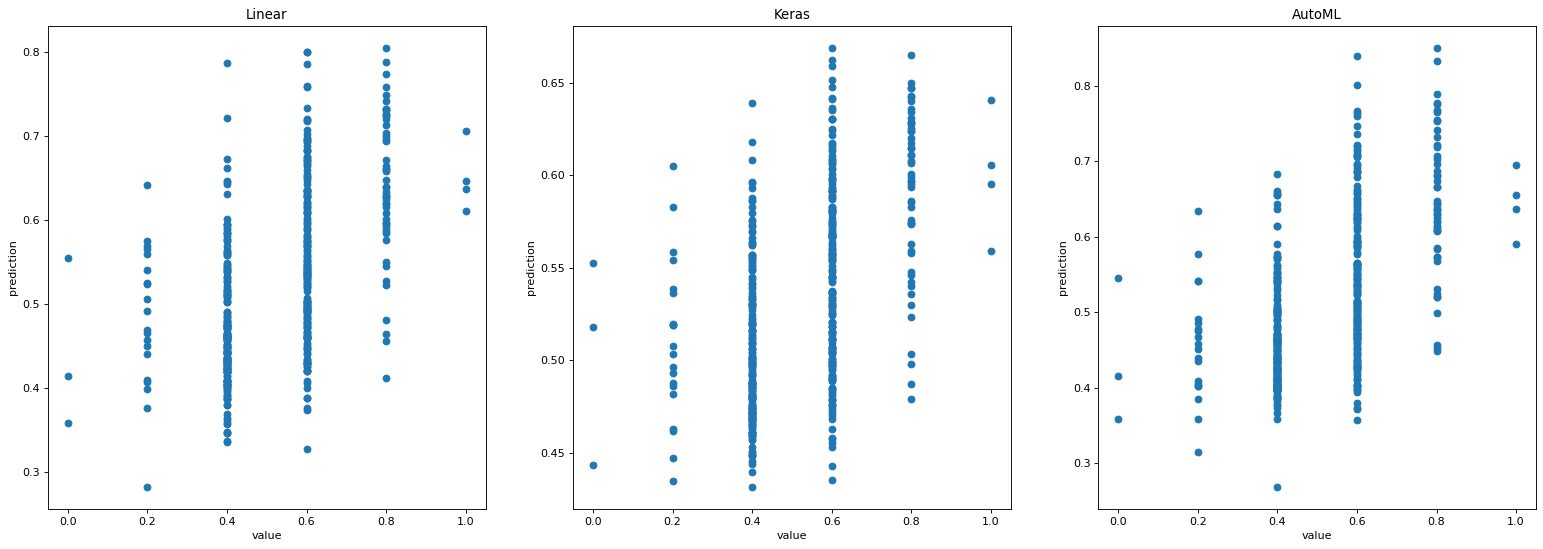

In [27]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(1, 3)
fig = plt.figure(figsize=(24, 8), dpi=80)
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_test, lr_test_pred)
ax1.update(dict(title='Linear', xlabel='value', ylabel='prediction'))

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(y_test, keras_test_pred)
ax2.update(dict(title='Keras', xlabel='value', ylabel='prediction'))

ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(y_test, am_test_pred)
ax3.update(dict(title='AutoML', xlabel='value', ylabel='prediction'))
plt.show()

**CONCLUSION:** The best results